# Importing necessary libraries and methods

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import re
import string
import gensim


## Methods
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import TFAutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
from collections import Counter



import matplotlib.pyplot as plt



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')




[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Reading & Overviewing the dataset 

In [5]:
DATASET_ENCODING = 'ISO-8859-1'
DATASET_COLUMNS = ['target','ids','date','flag','user','text']
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',
                   encoding=DATASET_ENCODING,names=DATASET_COLUMNS)


In [6]:
dataset

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# a) Preprocessing 

## Checking for missing values 

In [7]:
print(dataset.isna().sum())
print("luckly there isn't any missing values".upper())

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
LUCKLY THERE ISN'T ANY MISSING VALUES


## Removing the unnecessary columns 

In [8]:
dataset = dataset[['target','text']]
dataset

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


## Replacing the values for ease understanding

In [9]:
dataset.loc[dataset['target'] == 4, 'target'] = 1


## For testing purposes and saving time, list just take the first 1000 and last 1000 rows 

In [10]:
# take the first 1000 rows
df_top = dataset.head(1000)

# take the last 1000 rows
df_bottom = dataset.tail(1000)

dataset = pd.concat([df_top, df_bottom])

In [11]:
print(len(dataset))
dataset

2000


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## Plotting the distribution of the target

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

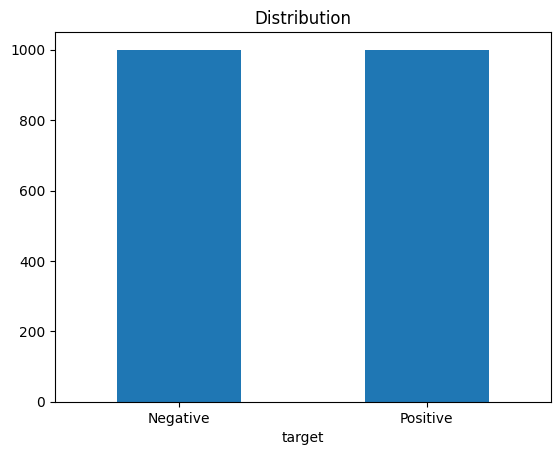

In [12]:
ax = dataset.groupby('target').count().plot(kind='bar',title='Distribution',legend=False)
ax.set_xticklabels(["Negative",'Positive'],rotation=0)

## Storing the text and target column in lists

In [13]:
text, target = list(dataset.text), list(dataset.target)


## Defining a set containing all stopwords in English 

In [14]:
stopwordlist = set(stopwords.words('english'))


In [15]:
print(stopwordlist)

{'off', 'am', 'in', 'ourselves', 'no', 'me', 'these', 'did', 've', 'doesn', "won't", 'has', 'for', 'which', "wouldn't", 'd', 'herself', 'can', 'their', 'couldn', 'against', 'during', 'down', "don't", 'be', 'don', 'your', 'were', 'the', 'further', 're', 'by', 'or', 'more', "isn't", 'theirs', 'himself', 'most', 'ours', 'that', 'it', 'having', 'from', "shan't", 'until', 'some', "mustn't", 'but', 'you', 'because', "needn't", 'was', "couldn't", 'is', "hadn't", 'both', "wasn't", 'between', 'again', "that'll", 'o', 't', 'of', "weren't", 'we', 'have', "didn't", 'hadn', 'nor', 'own', 'just', 'ma', 'do', 'll', 'my', 'through', 'shan', 'had', "you'd", 'his', "she's", 'weren', 'and', 'being', 'doing', 'above', 'this', 'there', 'only', 'mustn', 'whom', 'will', "you're", 'he', 'themselves', 'such', 'than', "you'll", 'any', 'yourself', 'about', 's', 'a', 'now', 'before', 'yourselves', 'i', 'then', 'to', 'all', 'should', 'its', "hasn't", "haven't", 'out', 'how', 'very', 'below', "it's", 'over', 'didn'

## Defining a dict containing emojis 

In [16]:
# emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
#           ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
#           ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
#           ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
#           '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
#           '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
#           ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [17]:
# # create a pandas Series from the list
# my_series = pd.Series(text)

# # define a function to apply to each element in the Series
# def find_key(element):
#     for key in emojis:
#         if key == element:
#             return emojis[key]
#     return None




In [18]:
# # apply the function to each element in the Series using the apply() method
# result = my_series.apply(find_key)

In [19]:
# No emigis 
# result.isna().sum()

## Preprocess function

In [20]:
def preprocess(textdata):
    processedText =[]



    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]\s"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with nothing
        tweet = re.sub(urlPattern, "", tweet,flags=re.MULTILINE)
        # Replace @USERNAME to nothing.
        tweet = re.sub(userPattern, "", tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, "", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # Remove punctuation
        tweet = tweet.translate(str.maketrans("","",string.punctuation))
            
            
        # Remove Stopwords
        tweetTokens = word_tokenize(tweet)
        filteredWords = [word for word in tweetTokens if word not in stopwordlist]
        
        # stemming 
        ps = PorterStemmer()
        stemmedWords = [ps.stem(word) for word in filteredWords]
        
        # Create Lemmatizer.
        wordLemm = WordNetLemmatizer()   
        lemmaWords = [wordLemm.lemmatize(word,pos='a') for word in stemmedWords]
        
        # Joining the words of a tweet 
        cleanTweet = " ".join(lemmaWords)
        
        # Adding the tweet to the processedText array
        processedText.append(cleanTweet)

    return processedText

In [21]:
processedtext = preprocess(text)


In [22]:
processedtext[:5]

['awwthat bummer shoulda got david carr third day itd',
 'upset cant updat facebook text itand might cri resultschool today alsoblah',
 'dive mani time ballmanag save 50 rest go bound',
 'whole bodi feel itchi like fire',
 'noit behav allim madwhi herebecaus cant see']

## After preprocessing the text let's check if there's any missing value

In [23]:
processedtextSerie  = pd.Series(processedtext)
emptyRows = processedtextSerie[processedtextSerie == ""].index
emptyRows

Int64Index([208, 249, 282, 398, 430, 555, 614, 1494, 1552, 1811, 1993], dtype='int64')

In [24]:
# dropping the empty rows
processedtextSerie.drop(emptyRows,inplace=True)

In [25]:
# Rechecking if there is any missing value
processedtextSerie[processedtextSerie == ""].index

Int64Index([], dtype='int64')

# b) Convert text data to numerical

## Bag of Words 

In [26]:

# Create bag of words
bag_of_words = Counter()
for tweet in processedtextSerie:
    words = tweet.split()
    bag_of_words.update(words)



In [27]:
print('word  count')
print('-'*15)
for i, (key, value) in enumerate(bag_of_words.items()):
    if i >= 10:
        break
    print(key, value)

word  count
---------------
awwthat 1
bummer 1
shoulda 1
got 67
david 2
carr 1
third 3
day 80
itd 1
upset 7


## Zipf's Law

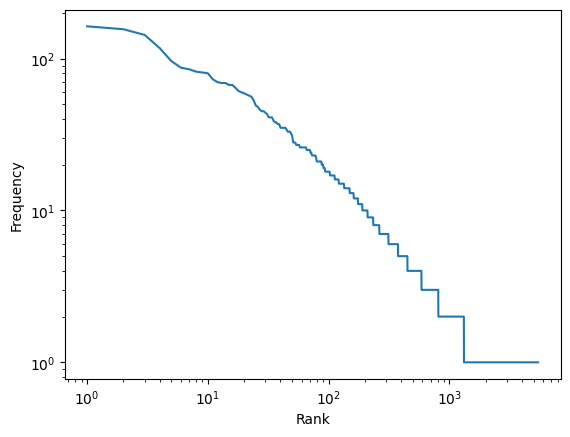

In [28]:
# Combine all the preprocessed tweets into one string
text = ' '.join(processedtextSerie)

# Tokenize the string into words
words = text.split()
# Count the frequency of each word
word_freq = Counter(words)
# Sort the words in descending order based on their frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
# Plot the frequency of each word against its rank
ranks = range(1, len(sorted_words)+1)
freqs = [freq for word, freq in sorted_words]

plt.plot(ranks, freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

In [29]:
sorted_words[:5]

[('im', 163), ('get', 156), ('go', 143), ('good', 117), ('like', 96)]

## N-Gram

In [30]:
# Define the n-gram order
n = 2

# Tokenize the tweets
tokenized_tweets = [nltk.word_tokenize(tweet) for tweet in processedtextSerie]

# Generate the n-grams for each tweet
ngrams_list = [list(nltk.ngrams(tweet, n)) for tweet in tokenized_tweets]

# Generate the n-grams
ngrams_list = [list(nltk.ngrams(tweet, n)) for tweet in tokenized_tweets]

#printing the 5 arrays in ngrams_list
ngrams_list[:5]

[[('awwthat', 'bummer'),
  ('bummer', 'shoulda'),
  ('shoulda', 'got'),
  ('got', 'david'),
  ('david', 'carr'),
  ('carr', 'third'),
  ('third', 'day'),
  ('day', 'itd')],
 [('upset', 'cant'),
  ('cant', 'updat'),
  ('updat', 'facebook'),
  ('facebook', 'text'),
  ('text', 'itand'),
  ('itand', 'might'),
  ('might', 'cri'),
  ('cri', 'resultschool'),
  ('resultschool', 'today'),
  ('today', 'alsoblah')],
 [('dive', 'mani'),
  ('mani', 'time'),
  ('time', 'ballmanag'),
  ('ballmanag', 'save'),
  ('save', '50'),
  ('50', 'rest'),
  ('rest', 'go'),
  ('go', 'bound')],
 [('whole', 'bodi'),
  ('bodi', 'feel'),
  ('feel', 'itchi'),
  ('itchi', 'like'),
  ('like', 'fire')],
 [('noit', 'behav'),
  ('behav', 'allim'),
  ('allim', 'madwhi'),
  ('madwhi', 'herebecaus'),
  ('herebecaus', 'cant'),
  ('cant', 'see')]]

## TF-IDF

In [31]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]+\b')

# Fit and transform the vectorizer on the tweets
tfidf_matrix = vectorizer.fit_transform(processedtextSerie)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Print the TF-IDF DataFrame
tfidf_df[:3]

,aand,aaron,aaw,abl,abouttequila,absolut,absolutelywev,abt,accentblockhh,accentlol,...,yup,yupp,ze,zealand,zip,zit,zone,zoo,zrovna,ztejasyum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word2Vec

In [32]:

# Splitting each tweet into a list of words
words = [tweet.split() for tweet in processedtextSerie]

# Training Word2Vec model on the preprocessed tweets
model = gensim.models.Word2Vec(words, min_count=1)

# Getting Word2Vec embedding for a particular word
embedding = model.wv['tweet']
print(embedding[:10])


[-0.00884975  0.00862574 -0.00227984 -0.00134085  0.0066679   0.00132033
  0.00719811  0.01206207  0.00423383 -0.01002444]


## BERT

In [33]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def encode_tweet(tweet):
    # Tokenize the tweet and add special tokens for BERT
    encoded = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    # Return the encoded tweet as a PyTorch tensor
    return encoded.input_ids
# Convert your pandas Series to a list
tweets = list(processedtextSerie)

# Encode each tweet using the BERT tokenizer
encoded_tweets = [encode_tweet(tweet) for tweet in tweets]

# Concatenate the encoded tweets into a single tensor
encoded_tepnsor = torch.cat(encoded_tweets, dim=0)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

In [34]:
encoded_tepnsor

tensor([[  101, 22091, 26677,  ...,     0,     0,     0],
        [  101,  6314,  2064,  ...,     0,     0,     0],
        [  101, 11529, 23624,  ...,     0,     0,     0],
        ...,
        [  101,  3191,  2072,  ...,     0,     0,     0],
        [  101,  5292,  9397,  ...,     0,     0,     0],
        [  101,  5292,  9397,  ...,     0,     0,     0]])